In [62]:
import json
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [63]:

import numpy as np

cvs = []
corpus_files = os.listdir("../corpus/")
for file in corpus_files:
    with open(f"../corpus/{file}", "r") as f:
        data = json.load(f)
    chapter_paragraph_counts = np.array([len(c["paragraphs"]) for c in data["chapters"]])
    cvs.append(np.std(chapter_paragraph_counts) / np.mean(chapter_paragraph_counts))
with open("tmp.txt", "w") as f:
    f.writelines([str(cv) + "\n" for cv in cvs])

In [64]:
df = pd.read_pickle("per_chapter_train_split_stats.pkl")
df = df[["word_count", "sentence_count", "paragraph_count", "chapter_count", "book"]]
df.head()

,word_count,sentence_count,paragraph_count,chapter_count,book
0,64692,3359,986,17,about/badenbad/badenbad.html
0,21003,634,117,55,abraham/fabparab/fabparab.html
0,9302,406,82,19,abraham/misc/misc.html
0,147207,6325,1716,68,achleitn/bergen/bergen.html
0,48213,2806,1314,12,achleitn/bezirks2/bezirks2.html


In [65]:
def book_to_filename(string: str) -> str:
    author, book, _ = tuple(string.split("/"))
    return f"{author}_{book}.json"

novels = []
for book in df["book"]:
    with open(f"../corpus/{book_to_filename(book)}", "r") as f:
        genre = json.load(f)["genre"]
    if genre == "Romane, Novellen und Erzählungen":
        novels.append(book)

# df = df[df["book"].isin(novels)]


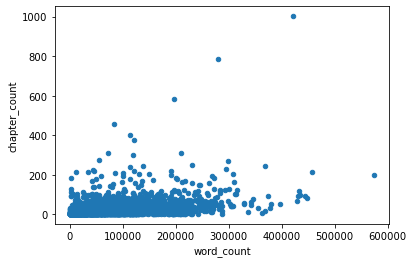

In [66]:
df.plot.scatter(x="word_count", y="chapter_count")
with open("tmp.txt", "w") as f:
    f.write("Word Count\n")
    f.writelines([str(wc) + "\n" for wc in df[df["chapter_count"] < 400]["word_count"]])
    f.write("Chapter Count\n")
    f.writelines([str(cc) + "\n" for cc in df[df["chapter_count"] < 400]["chapter_count"]])
plt.show()

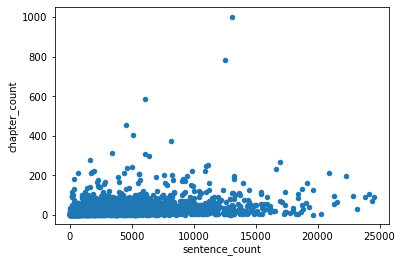

In [67]:
df.plot.scatter(x="sentence_count", y="chapter_count")
with open("tmp.txt", "w") as f:
    f.write("Sentence Count\n")
    f.writelines([str(sc) + "\n" for sc in df[df["chapter_count"] < 400]["sentence_count"]])
    f.write("Chapter Count\n")
    f.writelines([str(cc) + "\n" for cc in df[df["chapter_count"] < 400]["chapter_count"]])
plt.show()

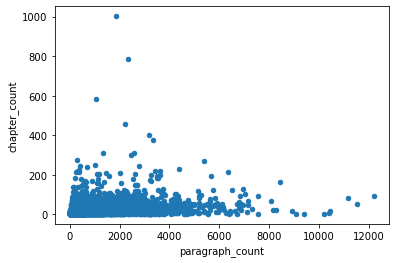

In [68]:
df.plot.scatter(x="paragraph_count", y="chapter_count")
with open("tmp.txt", "w") as f:
    f.write("Paragraph Count\n")
    f.writelines([str(pc) + "\n" for pc in df[df["chapter_count"] < 400]["paragraph_count"]])
    f.write("Chapter Count\n")
    f.writelines([str(cc) + "\n" for cc in df[df["chapter_count"] < 400]["chapter_count"]])
plt.show()

In [69]:
df.corr(method="spearman")

,word_count,sentence_count,paragraph_count,chapter_count
word_count,1.000000,0.913789,0.777917,0.453660
sentence_count,0.913789,1.000000,0.884913,0.437715
paragraph_count,0.777917,0.884913,1.000000,0.396108
chapter_count,0.453660,0.437715,0.396108,1.000000


In [83]:
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


def regress_and_plot(df, column):
    x = np.array(df[column]).reshape(-1, 1)
    y = np.array(df["chapter_count"]).reshape(-1, 1)
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, shuffle=True, random_state=6948050
    )
    # fit
    model = linear_model.LinearRegression(fit_intercept=True)
    model.fit(x_train, y_train)
    # predict
    y_pred = model.predict(x_test)
    print(y_pred[:5])

    print(
        "RMSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 2),
         "MSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True), 2),
        "MAE:",
        round(mean_absolute_error(y_true=y_test, y_pred=y_pred), 3),
        "R2:",
        model.score(x_test, y_test),
    )
    print("chapter")
    print(x_test)
    print(column)
    print(y_test)
    print("pred")
    print(y_pred)
    print(model.intercept_)
    print(model.coef_)
    plt.scatter(x_test, y_test, color="black")
    plt.plot(x_test, y_pred, color="blue")
    plt.xlabel(column)
    plt.ylabel("chapter_count")
    plt.show()

[[29.87120846]
 [22.91871648]
 [30.29966017]
 [25.92275183]
 [13.99615886]]
RMSE: 41.8 MSE: 1747.36 MAE: 16.017 R2: 0.14500949913049055


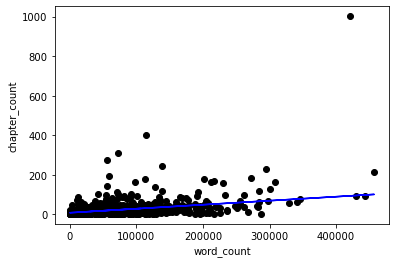

[[27.91878249]
 [24.12138305]
 [32.15931968]
 [25.50254963]
 [14.14269714]]
RMSE: 43.48 MSE: 1890.34 MAE: 16.94 R2: 0.07504913186274831


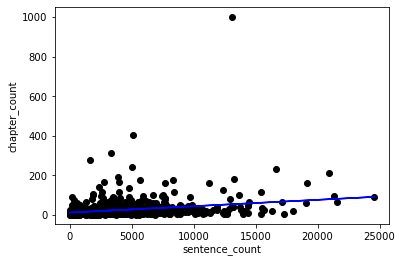

[[26.21394482]
 [25.8493828 ]
 [27.44591301]
 [21.31121426]
 [16.90504231]]
RMSE: 44.43 MSE: 1974.25 MAE: 17.166 R2: 0.03398783617260215


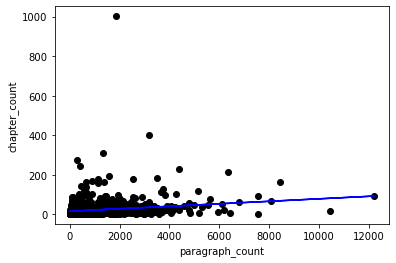

In [71]:
regress_and_plot(df, "word_count")
regress_and_plot(df, "sentence_count")
regress_and_plot(df, "paragraph_count")

In [72]:
# multiple linear regression

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

x = zip(df["word_count"], df["sentence_count"], df["paragraph_count"])
x = np.array(list(x))
y = np.array(df["chapter_count"]).reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=6948050
)
# fit
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
print("Word Count, Sentence Count, Paragraph Count")
print(model.coef_)
print(model.intercept_)
# predict
y_pred = model.predict(x_test)
print(y_pred[:10])

print(
        "RMSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 2),
         "MSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True), 2),
        "MAE:",
        round(mean_absolute_error(y_true=y_test, y_pred=y_pred), 3),
        "R2:",
        model.score(x_test, y_test),
    )

Word Count, Sentence Count, Paragraph Count
[[ 0.00023188  0.00042996 -0.00326823]]
[8.84542578]
[[30.15387992]
 [21.8991824 ]
 [30.56626635]
 [27.87292815]
 [15.03421235]
 [21.96787592]
 [22.79716082]
 [15.92245986]
 [47.00786657]
 [10.82890208]]
RMSE: 41.53 MSE: 1724.54 MAE: 16.121 R2: 0.15617192069784014


In [73]:
pred_df = pd.read_pickle("../results/predictions_finetuned_2e-5_bs32_e3_best.pkl")

In [74]:
from scipy.signal import argrelmin, find_peaks, argrelmax
import math

maxima_stats = []
for name, group in pred_df.groupby(["book_path"]):
    chapter_count = group["chapter_idx"].max()
    confidences = np.array(group["logit_0"])
    maxima = argrelmax(confidences)[0]
    candidates = group[group["logit_0"] > group["logit_1"]]
    normalized_logit_0 = (group["logit_0"] - group["logit_0"].min())/(group["logit_0"].max() - group["logit_0"].min())
    log_confidence = [-math.log(1 - l + 1e-10) for l in normalized_logit_0]
    log_threshold_candidates = [c > 0.99 for c in log_confidence]
    maxima_stats.append(
        {
            "book_path": name,
            "chapter_count": chapter_count,
            "maxima_count": len(maxima),
            "candidate_count": len(candidates),
            "log_candidate_count": len(log_threshold_candidates)
        }
    )

maxima_df = pd.DataFrame(maxima_stats)
maxima_df.head()

,book_path,chapter_count,maxima_count,candidate_count,log_candidate_count
0,about_bergkoen.json,9,321,110,1058
1,about_parisehe.json,12,372,104,1286
2,abraham_fabeln.json,4,4,7,14
3,abraham_narrnest.json,11,23,45,79
4,achleitn_bezirks1.json,4,335,68,1170


In [75]:
novels = []
for book in maxima_df["book_path"]:
    with open(f"../corpus/{book}", "r") as f:
        genre = json.load(f)["genre"]
    if genre == "Romane, Novellen und Erzählungen":
        novels.append(book)

# maxima_df = maxima_df[maxima_df["book_path"].isin(novels)]

In [76]:
maxima_df.sort_values(by="chapter_count", ascending=False).head()

,book_path,chapter_count,maxima_count,candidate_count,log_candidate_count
878,schoeppn_bysagen.json,1345,1231,1973,4058
618,lespinas_briefe.json,226,663,662,2079
868,schmid_erzjugen.json,202,113,219,325
385,grimm_maerchen.json,198,663,492,2149
437,hebel_hausfreu.json,190,161,258,514


In [77]:
maxima_df = maxima_df[maxima_df["book_path"] != "schoeppn_bysagen.json"]

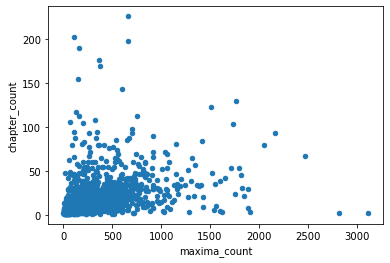

In [78]:
maxima_df.plot.scatter(x="maxima_count", y="chapter_count")
with open("tmp.txt", "w") as f:
    f.write("Maxima Count\n")
    f.writelines([str(wc) + "\n" for wc in maxima_df[maxima_df["chapter_count"] < 400]["maxima_count"]])
    f.write("Chapter Count\n")
    f.writelines([str(cc) + "\n" for cc in maxima_df[maxima_df["chapter_count"] < 400]["chapter_count"]])
plt.show()

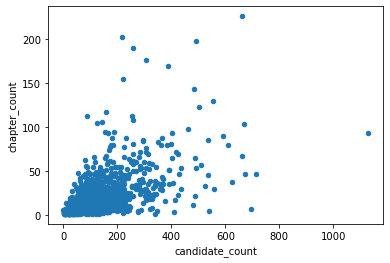

In [79]:
maxima_df.plot.scatter(x="candidate_count", y="chapter_count")
with open("tmp.txt", "w") as f:
    f.write("Candidate Count\n")
    f.writelines([str(wc) + "\n" for wc in maxima_df[maxima_df["chapter_count"] < 400]["candidate_count"]])
    f.write("Chapter Count\n")
    f.writelines([str(cc) + "\n" for cc in maxima_df[maxima_df["chapter_count"] < 400]["chapter_count"]])
plt.show()

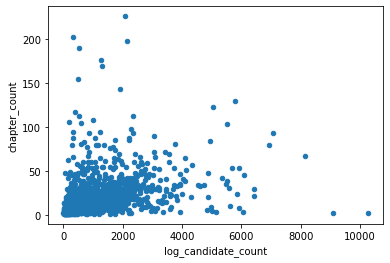

In [80]:
maxima_df.plot.scatter(x="log_candidate_count", y="chapter_count")
with open("tmp.txt", "w") as f:
    f.write("Log Candidate Count\n")
    f.writelines([str(wc) + "\n" for wc in maxima_df[maxima_df["chapter_count"] < 400]["log_candidate_count"]])
    f.write("Chapter Count\n")
    f.writelines([str(cc) + "\n" for cc in maxima_df[maxima_df["chapter_count"] < 400]["chapter_count"]])
plt.show()

In [46]:
maxima_df[["maxima_count", "candidate_count", "log_candidate_count", "chapter_count"]].corr(method="spearman")

,maxima_count,candidate_count,log_candidate_count,chapter_count
maxima_count,1.000000,0.750455,0.998847,0.470666
candidate_count,0.750455,1.000000,0.745577,0.600139
log_candidate_count,0.998847,0.745577,1.000000,0.466558
chapter_count,0.470666,0.600139,0.466558,1.000000


[[64.09238689]
 [24.13683026]
 [23.18550748]
 [34.00680407]
 [47.44423829]]
RMSE: 20.24 MSE: 409.81 MAE: 11.855 R2: 0.33681238558946514
chapter
[[487]
 [151]
 [143]
 [234]
 [347]
 [279]
 [ 66]
 [  2]
 [146]
 [539]
 [ 73]
 [212]
 [140]
 [121]
 [ 73]
 [363]
 [406]
 [ 33]
 [186]
 [167]
 [ 92]
 [ 71]
 [216]
 [253]
 [153]
 [124]
 [188]
 [ 73]
 [ 71]
 [ 99]
 [299]
 [144]
 [ 16]
 [ 74]
 [295]
 [  7]
 [ 74]
 [158]
 [159]
 [ 71]
 [ 78]
 [ 85]
 [ 92]
 [ 65]
 [316]
 [164]
 [113]
 [ 79]
 [ 43]
 [324]
 [200]
 [234]
 [113]
 [165]
 [ 67]
 [168]
 [ 64]
 [ 23]
 [175]
 [674]
 [ 77]
 [ 90]
 [205]
 [ 90]
 [191]
 [ 72]
 [ 68]
 [135]
 [ 69]
 [ 86]
 [138]
 [211]
 [202]
 [ 53]
 [ 28]
 [120]
 [174]
 [191]
 [ 62]
 [ 39]
 [270]
 [502]
 [239]
 [ 90]
 [281]
 [145]
 [ 74]
 [230]
 [ 79]
 [ 34]
 [ 95]
 [156]
 [124]
 [104]
 [101]
 [ 75]
 [ 84]
 [ 93]
 [273]
 [ 51]
 [232]
 [243]
 [168]
 [114]
 [170]
 [696]
 [278]
 [256]
 [ 93]
 [103]
 [323]
 [121]
 [137]
 [185]
 [ 32]
 [ 77]
 [195]
 [140]
 [ 84]
 [109]
 [ 87]
 [151]
 [

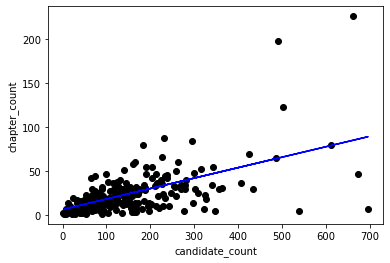

: 

In [84]:
regress_and_plot(maxima_df, "candidate_count")

[[18.10023445]
 [17.68523326]
 [17.70252497]
 [17.68523326]
 [15.62751901]]
RMSE: 19.66 MSE: 386.36 MAE: 12.664 R2: 0.17684263127040556


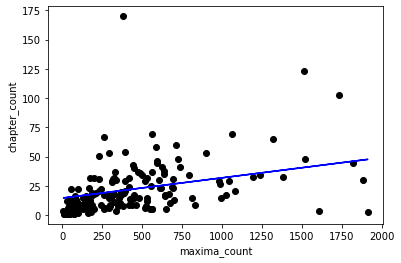

[[14.28364338]
 [11.65345308]
 [12.04798162]
 [13.49458629]
 [ 6.91911054]]
RMSE: 15.86 MSE: 251.66 MAE: 10.163 R2: 0.46382074024725706


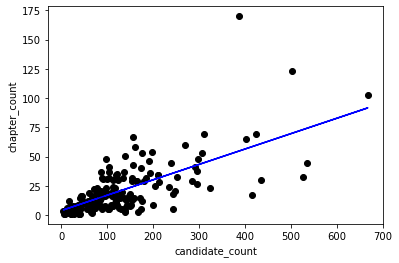

[[18.1567681 ]
 [17.94235999]
 [17.78024655]
 [17.70703403]
 [15.5891003 ]]
RMSE: 19.64 MSE: 385.82 MAE: 12.671 R2: 0.17799561100344408


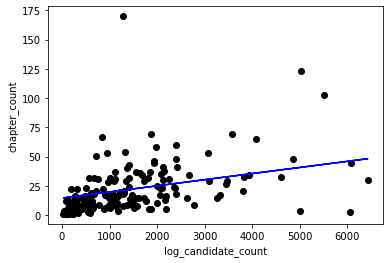

In [47]:
regress_and_plot(maxima_df, "maxima_count")
regress_and_plot(maxima_df, "candidate_count")
regress_and_plot(maxima_df, "log_candidate_count")

In [48]:
# multiple linear regression

from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

x = zip(maxima_df["maxima_count"], maxima_df["candidate_count"], maxima_df["log_candidate_count"])
x = np.array(list(x))
y = np.array(maxima_df["chapter_count"]).reshape(-1, 1)
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, shuffle=True, random_state=6948050
)
print(len(x_train))
print(len(x_test))
# fit
model = linear_model.LinearRegression(fit_intercept=True)
model.fit(x_train, y_train)
print("Maxima Count, Candidate Count, Log Candidate Count")
print(model.coef_)
print(model.intercept_)
# predict
y_pred = model.predict(x_test)
print(y_pred[:10])

print(
        "RMSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=False), 2),
         "MSE:",
        round(mean_squared_error(y_true=y_test, y_pred=y_pred, squared=True), 2),
        "MAE:",
        round(mean_absolute_error(y_true=y_test, y_pred=y_pred), 3),
        "R2:",
        model.score(x_test, y_test),
    )


681
171
Maxima Count, Candidate Count, Log Candidate Count
[[ 0.04883721  0.14859936 -0.01725347]]
[4.81525645]
[[14.76222061]
 [11.32553272]
 [12.35502572]
 [14.18233016]
 [ 7.92839094]
 [13.44528882]
 [12.37972642]
 [14.7993055 ]
 [22.26999869]
 [14.99222436]]
RMSE: 15.71 MSE: 246.75 MAE: 10.199 R2: 0.4742788188918262


In [49]:
# # ONLY FOR INITIAL CREATION

# import nltk
# from nltk.tokenize import word_tokenize, sent_tokenize
# import os
# import pandas as pd
# import json
# from sklearn.model_selection import train_test_split
# from tqdm import tqdm

# nltk.download("punkt")

# df_list = []
# corpus_files = os.listdir("../corpus/")
# corpus_files.sort()
# print(len(corpus_files))
# train, _ = train_test_split(
#     corpus_files, train_size=0.8, shuffle=True, random_state=6948050
# )

# for file in train:
#     with open(f"../corpus/{file}", "r", encoding="utf8") as f:
#         d = json.load(f)
#         df = pd.DataFrame(d)
#         df = df.drop(columns=["author", "webpath", "title"])
#         df["filepath"] = df["filepath"].apply(
#             lambda x: x.replace(
#                 "/mnt/c/Users/Moritz Lahann/Desktop/STUDIUM/Module IAS/Master's Thesis/gutenberg-edition16/",
#                 "",
#             )
#         )
#         df_list.append(df)

# df = pd.concat(df_list)
# df.head()

# grouped_df = df.groupby(by=["filepath"])
# books_df_list = []
# for name, group in tqdm(grouped_df):
#     word_sum = sentence_sum = paragraph_sum = 0
#     for chapter in group["chapters"]:
#         word_count = sum(
#             [len(word_tokenize(p, language="german")) for p in chapter["paragraphs"]]
#         )
#         word_sum += word_count
#         sentence_count = sum(
#             [len(sent_tokenize(p, language="german")) for p in chapter["paragraphs"]]
#         )
#         sentence_sum += sentence_count
#         paragraph_count = len(chapter["paragraphs"])
#         paragraph_sum += paragraph_count

#     books_df_list.append(
#         pd.DataFrame(
#             {
#                 "paragraph_count": [paragraph_sum],
#                 "word_count": [word_sum],
#                 "sentence_count": [sentence_sum],
#                 "book": [name],
#                 "chapter_count": len(group["chapters"]),
#             }
#         )
#     )

# stats_df = pd.concat(books_df_list)
# stats_df.to_pickle("per_chapter_train_split_stats.pkl")